## Combined Model Testing
This notebook runs through the code for combining our classifcation and localization model predictions, to draw both the class and bounding box predictions on a sample of images.

In [37]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

In [38]:
train = pd.read_csv("train_bbox.csv")
y = train.drop(columns='image_id')
y = y.to_numpy()

In [39]:
def calculate_iou(pred_bbox, true_bbox):
    """
    Calculates the Intersection over Union (IoU) score between
    the predicted and true bounding box provided.
    """
    
    pred_x0 = pred_bbox[0]
    pred_y0 = pred_bbox[1]
    pred_x1 = pred_x0 + pred_bbox[2]
    pred_y1 = pred_y0 + pred_bbox[3]

    true_x0 = true_bbox[0]
    true_y0 = true_bbox[1]
    true_x1 = true_x0 + true_bbox[2]
    true_y1 = true_y0 + true_bbox[3]

    x_left = max(pred_x0, true_x0)
    y_top = max(pred_y0, true_y0)
    x_right = min(pred_x1, true_x1)
    y_bottom = min(pred_y1, true_y1)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    pred_bbox_area = (pred_x1 - pred_x0) * (pred_y1 - pred_y0)
    true_bbox_area = (true_x1 - true_x0) * (true_y1 - true_y0)

    iou = intersection_area / (pred_bbox_area + true_bbox_area - intersection_area)
    return iou

In [40]:
def mean_iou(y_true, y_pred):
    """
    Calculates the mean Intersection over Union (IoU) score 
    between all predicted and true bounding boxes provided.
    """
    
    try: # Incase input are tensors
        y_true = y_true.numpy() 
        y_pred = y_pred.numpy()
    except:
        pass

    ious = np.array([])

    for i in range(len(y_true)):
        ious = np.append(ious, calculate_iou(y_pred[i], y_true[i]))

    return np.mean(ious)

In [41]:
model_classifier = keras.models.load_model("model_classification.h5")
model_bbox = keras.models.load_model("model_localizer.h5",  custom_objects={"mean_iou": mean_iou})

In [42]:
label_dict = {0: 'healthy', 1: 'multiple', 2: 'rust', 3: 'scab'}

train_images = []
 
IMG_WIDTH = 200
IMG_HEIGHT = 150

for num in range(100): 
    path = "plant-pathology-2020-fgvc7/images/Train_" + str(num) + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    train_images.append(image)
    
train_images = np.array(train_images)
train_images_scaled = train_images / 255

In [43]:
test_images = []

for num in range(100): 
    path = "plant-pathology-2020-fgvc7/images/Test_" + str(num) + ".jpg"
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    test_images.append(image)
    
test_images = np.array(test_images)
test_images_scaled = test_images / 255

In [53]:
def plot_bboxes(images, y_pred, lower, upper, y_true=None):
    """
    Plots the predicted bounding boxes on the set of images specified, 
    as well as the true bounding boxes, if provided.
    
    images: the set of images
    y_pred: the predicted bboxes
    lower: the start range of images to show
    upper: the end range of images to show
    y_true: the true bboxes
    
    """
    
    fig, ax = plt.subplots(1, upper - lower, figsize=(20, 6))

    for i in range(lower, upper):

        image_copy = images[i].copy()
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)

        if y_true is not None:
            x0 = int(y_true[i][0] * IMG_WIDTH) 
            y0 = int(y_true[i][1] * IMG_HEIGHT)
            x1 = int((y_true[i][0] + y_true[i][2]) * IMG_WIDTH)
            y1 = int((y_true[i][1] + y_true[i][3]) * IMG_HEIGHT)

            image_copy = cv2.rectangle(image_copy, (x0, y0), (x1, y1), (0, 255, 0), 2)
            iou = round(calculate_iou(y_pred[i], y_true[i]), 3)
            ax[i - lower].set_title(f"IoU: {iou}")

        x0 = int(y_pred[i][0] * IMG_WIDTH)
        y0 = int(y_pred[i][1] * IMG_HEIGHT)
        x1 = int((y_pred[i][0] + y_pred[i][2]) * IMG_WIDTH)
        y1 = int((y_pred[i][1] + y_pred[i][3]) * IMG_HEIGHT)

        image_copy = cv2.rectangle(image_copy, (x0, y0), (x1, y1), (255, 0, 0), 2)

        ax[i - lower].set_axis_off()
        ax[i - lower].imshow(image_copy) 

In [55]:
def plot_bboxes_and_class(images, y_pred_bbox, y_pred_class, lower, upper):
    """
    Plots the predicted bounding boxes and predicted class on the 
    set of images specified, 
    
    images: the set of images
    y_pred_bbox: the predicted bboxes
    y_pred_class: the predicted classes
    lower: the start range of images to show
    upper: the end range of images to show
    
    """
        
    fig, ax = plt.subplots(1, upper - lower, figsize=(20, 6))

    for i in range(lower, upper):

        image_copy = images[i].copy()
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)
        label = np.argmax(y_pred_class, axis=1)[i]

        x0 = int(y_pred_bbox[i][0] * IMG_WIDTH)
        y0 = int(y_pred_bbox[i][1] * IMG_HEIGHT)
        x1 = int((y_pred_bbox[i][0] + y_pred_bbox[i][2]) * IMG_WIDTH)
        y1 = int((y_pred_bbox[i][1] + y_pred_bbox[i][3]) * IMG_HEIGHT)

        label_width = 40 if len(label_dict[label]) == 4 else 60
        image_copy = cv2.rectangle(image_copy, (x0, y1-20), (x0+label_width, y1), (0, 0, 0), -1)
        image_copy = cv2.rectangle(image_copy, (x0, y0), (x1, y1), (255, 0, 0), 2)
        image_copy = cv2.putText(image_copy, label_dict[label], (x0+5, y1-7), cv2.FONT_HERSHEY_DUPLEX, 0.4, (255, 255, 255), 1)

        ax[i - lower].set_axis_off()
        ax[i - lower].imshow(image_copy) 

In [56]:
y_pred_class = model_classifier.predict(train_images_scaled)
y_pred_bbox = model_bbox.predict(train_images_scaled)

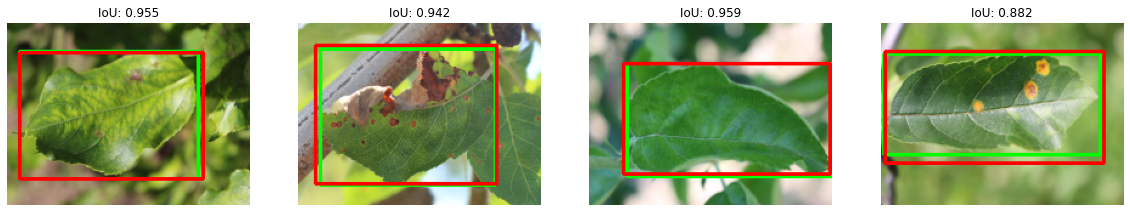

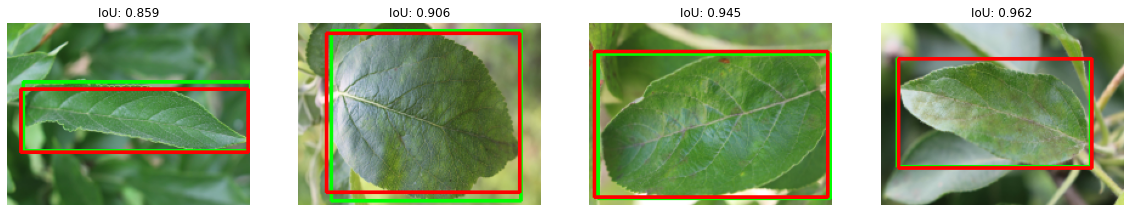

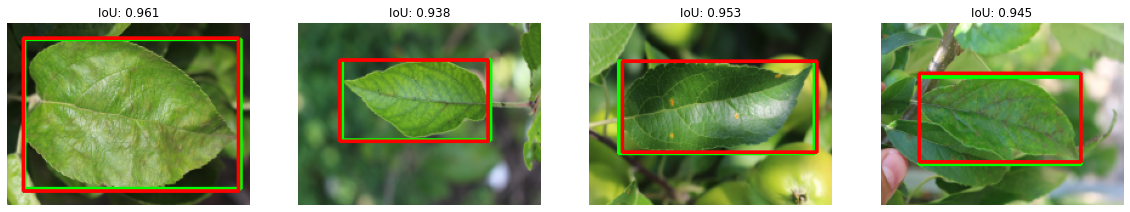

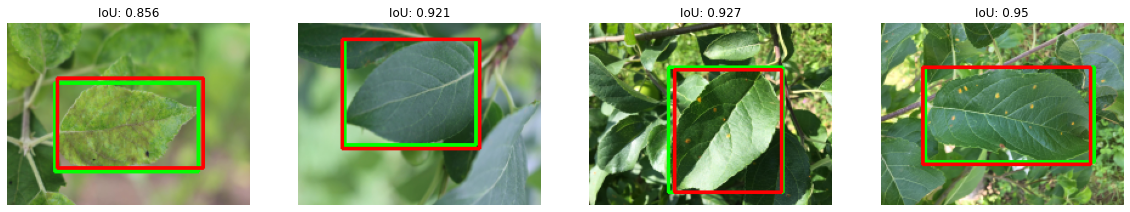

In [57]:
for i in range(0, 16, 4):
    plot_bboxes(train_images, y_pred_bbox, i, i+4, y)

In [58]:
y_pred_class = model_classifier.predict(test_images_scaled)
y_pred_bbox = model_bbox.predict(test_images_scaled)

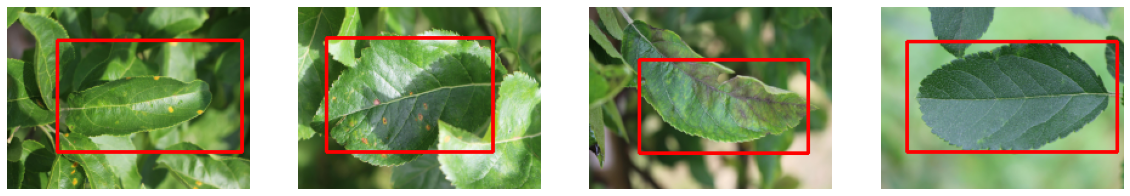

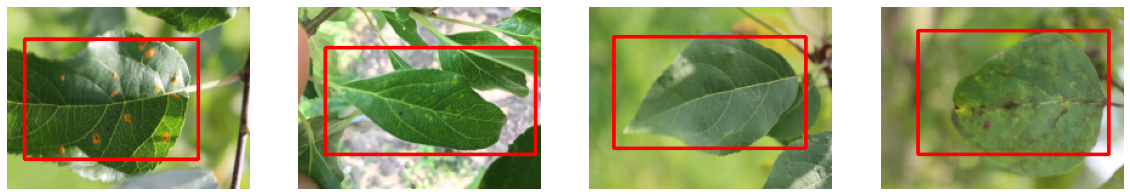

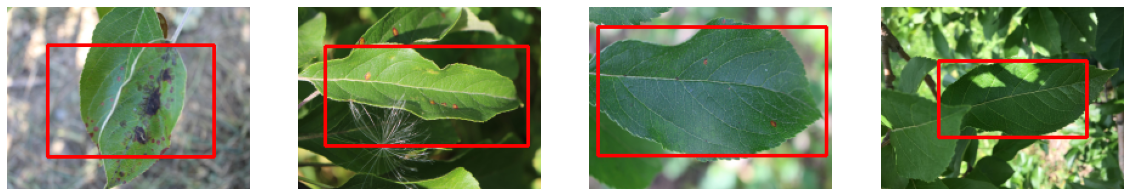

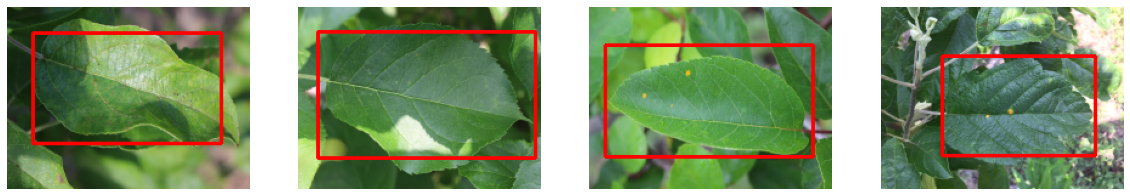

In [59]:
for i in range(0, 16, 4):
    plot_bboxes(test_images, y_pred_bbox, i, i+4)

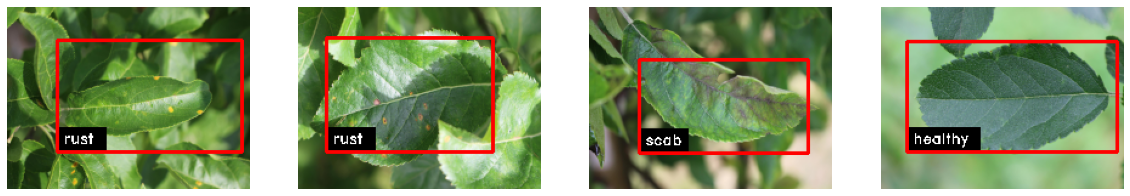

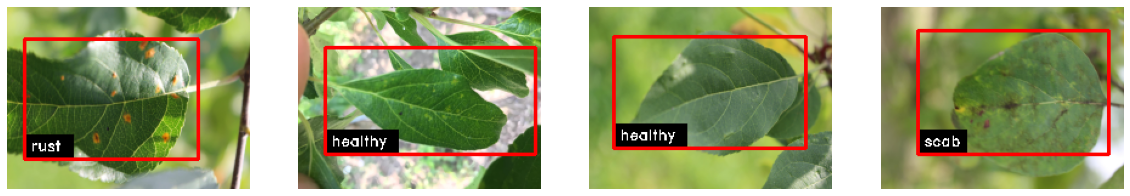

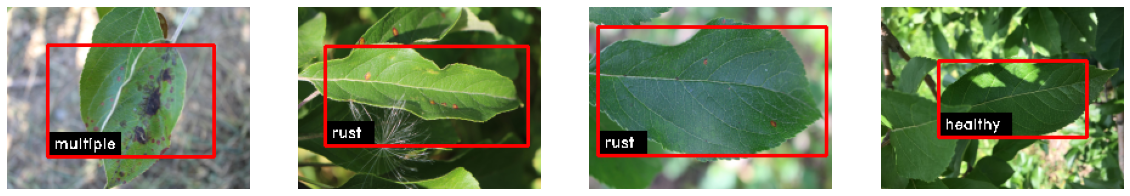

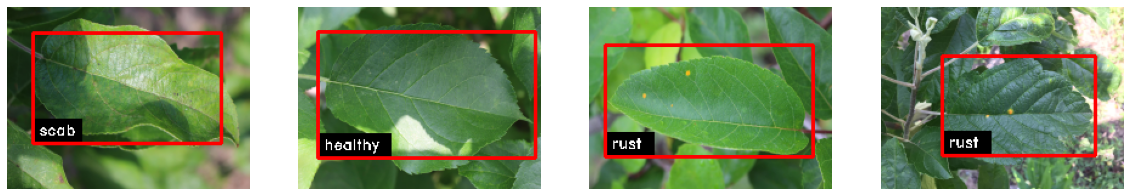

In [50]:
for i in range(0, 16, 4):
    plot_bboxes_and_class(test_images, y_pred_bbox, y_pred_class, i, i+4)

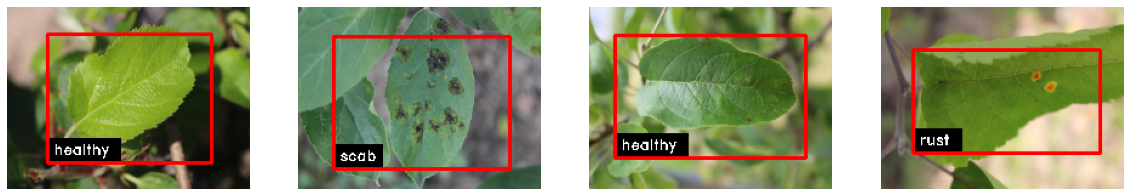

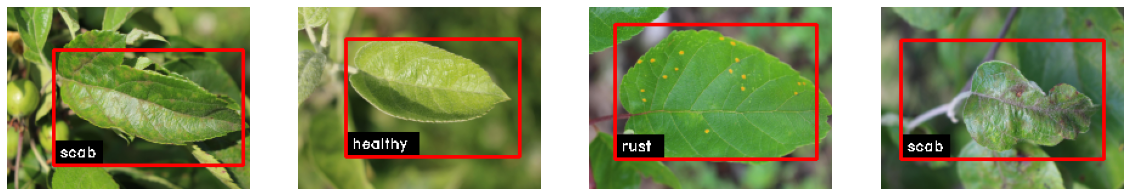

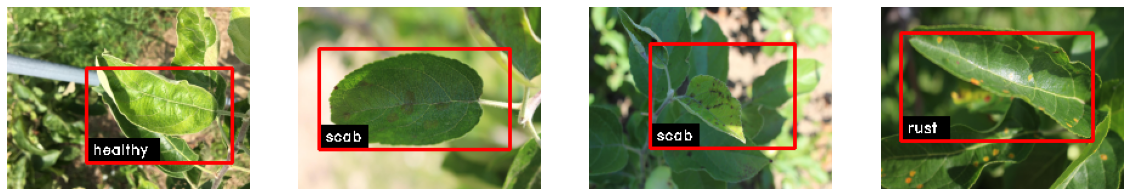

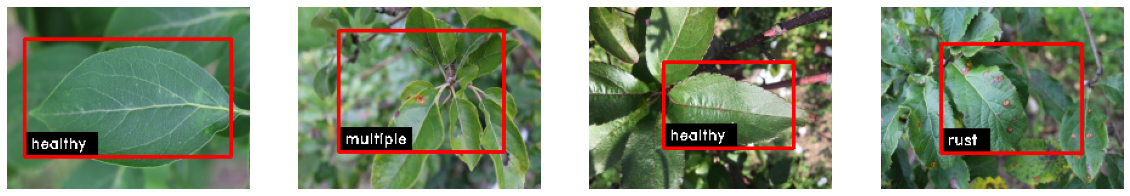

In [52]:
for i in range(16, 32, 4):
    plot_bboxes_and_class(test_images, y_pred_bbox, y_pred_class, i, i+4)